<a href="https://colab.research.google.com/github/OJB-Quantum/Cool-Mesh-Files/blob/main/Google%20Colab%20Notebooks/SVG_PNG_to_GEO_Mesh_Conversion_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [1]:
# Colab: install the geometry + image stack with pinned Pillow version
!pip -q install --upgrade shapely cairosvg scikit-image "pillow<12.0" matplotlib pylint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.4/536.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.0 MB/s eta 0:00:00


In [2]:
from __future__ import annotations

import io
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Sequence, Tuple

import cairosvg
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from shapely.affinity import scale as shp_scale
from shapely.affinity import translate as shp_translate
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
from skimage import measure, morphology


# Required: set plot DPI via rcParams (Colab inline + saved figures).
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["savefig.dpi"] = 200


@dataclass(frozen=True)
class SvgPngToGeoConfig:
    """Configuration for converting an SVG or PNG silhouette into a Gmsh GEO file."""

    # Geometry scaling
    target_width_mm: float = 1.0

    # 2D vs 3D (extruded) GEO generation
    generate_3d: bool = False
    extrude_thickness_mm: float = 0.1
    extrude_layers: int = 1

    # SVG rasterization and PNG handling
    raster_px_width: int = 4000
    alpha_threshold: int = 0  # 0..255, where > threshold is considered "solid"

    # Mask cleanup
    remove_small_objects_min_px: int = 50
    close_radius_px: int = 1

    # Polygon conditioning
    simplify_tolerance_mm: float = 0.0005  # 0.5 µm, post-scaling simplification
    min_polygon_area_mm2: float = 1e-10
    max_points_per_ring: int = 800

    # Mesh sizing field (Distance -> Threshold) defaults.
    # If any are None, they will be derived from target_width_mm.
    lc_min_mm: Optional[float] = None
    lc_max_mm: Optional[float] = None
    dist_min_mm: Optional[float] = None
    dist_max_mm: Optional[float] = None
    distance_sampling: int = 200

    # Gmsh GEO style
    use_opencascade_factory: bool = True
    write_mesh_field: bool = True

    # Optional CFD-ish boundary layer support (OFF by default).
    # This is generally more appropriate than isotropic sizing for CFD.
    use_boundary_layer_field: bool = False
    boundary_layer_first_layer_mm: float = 0.001
    boundary_layer_thickness_mm: float = 0.02
    boundary_layer_growth_ratio: float = 1.2
    boundary_layer_quads: int = 1


def _flatten_to_polygons(geom: Polygon | MultiPolygon) -> List[Polygon]:
    """Flatten a shapely Polygon/MultiPolygon into a list of Polygons."""
    if isinstance(geom, Polygon):
        return [geom]
    return [g for g in geom.geoms if isinstance(g, Polygon)]


def _signed_area_xy(coords_xy: np.ndarray) -> float:
    """Return signed polygon area (positive for counterclockwise orientation)."""
    x = coords_xy[:, 0]
    y = coords_xy[:, 1]
    return 0.5 * float(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))


def _decimate_ring(coords_xy: np.ndarray, max_points: int) -> np.ndarray:
    """Downsample a ring to at most max_points points, preserving order."""
    if coords_xy.shape[0] <= max_points:
        return coords_xy
    idx = np.linspace(0, coords_xy.shape[0] - 1, max_points, dtype=int)
    coords_ds = coords_xy[idx]
    return coords_ds


def _dedupe_consecutive(coords_xy: np.ndarray, eps: float = 1e-15) -> np.ndarray:
    """Remove consecutive duplicate points in a coordinate sequence."""
    if coords_xy.shape[0] < 2:
        return coords_xy
    diffs = np.abs(coords_xy[1:] - coords_xy[:-1]).max(axis=1)
    keep = np.concatenate(([True], diffs > eps))
    return coords_xy[keep]


def _ensure_orientation(coords_xy: np.ndarray, clockwise: bool) -> np.ndarray:
    """Ensure ring orientation (clockwise or counterclockwise)."""
    area = _signed_area_xy(coords_xy)
    is_ccw = area > 0.0
    if clockwise and is_ccw:
        return coords_xy[::-1].copy()
    if (not clockwise) and (not is_ccw):
        return coords_xy[::-1].copy()
    return coords_xy


def _derive_mesh_sizes(config: SvgPngToGeoConfig) -> Tuple[float, float, float, float]:
    """Derive lc/distance parameters if user left them unset."""
    # A “reasonably dense” default that scales with overall size.
    # For a 1 mm wide design, lc_min defaults to ~3 µm.
    lc_min = config.lc_min_mm if config.lc_min_mm is not None else config.target_width_mm / 333.0
    lc_max = config.lc_max_mm if config.lc_max_mm is not None else 4.0 * lc_min
    dist_min = config.dist_min_mm if config.dist_min_mm is not None else 1.0 * lc_min
    dist_max = config.dist_max_mm if config.dist_max_mm is not None else 5.0 * lc_min
    return lc_min, lc_max, dist_min, dist_max


Saving IBM_logo.svg to IBM_logo.svg
Loaded: IBM_logo.svg
Image size (px): (4000, 1493)


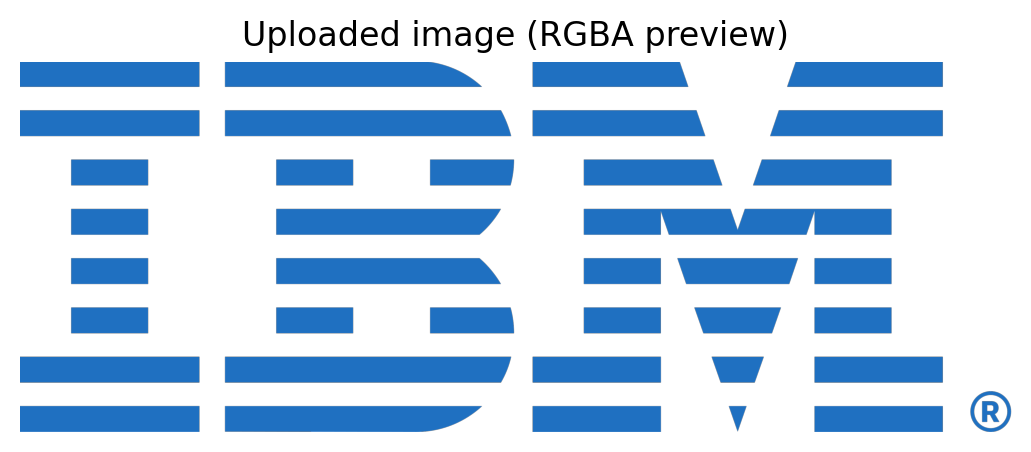

In [3]:
def upload_one_file() -> Tuple[str, bytes]:
    """Prompt the user to upload exactly one file in Colab."""
    from google.colab import files  # pylint: disable=import-error

    uploaded: Dict[str, bytes] = files.upload()
    if not uploaded:
        raise RuntimeError("No file uploaded. Please upload an SVG or PNG.")
    if len(uploaded) != 1:
        names = list(uploaded.keys())
        raise RuntimeError(f"Please upload exactly one file, not {len(names)}: {names}")
    name, content = next(iter(uploaded.items()))
    return name, content


def load_rgba_image(name: str, content: bytes, config: SvgPngToGeoConfig) -> Image.Image:
    """Load an SVG or PNG/JPG image into an RGBA PIL Image.

    Args:
      name: Filename from upload.
      content: Raw uploaded bytes.
      config: Conversion configuration.

    Returns:
      A PIL Image in RGBA mode.
    """
    suffix = Path(name).suffix.lower()

    if suffix == ".svg":
        png_bytes = cairosvg.svg2png(bytestring=content, output_width=config.raster_px_width)
        img = Image.open(io.BytesIO(png_bytes)).convert("RGBA")
        return img

    if suffix in {".png", ".jpg", ".jpeg"}:
        img = Image.open(io.BytesIO(content)).convert("RGBA")
        return img

    raise ValueError(f"Unsupported file extension: {suffix}. Use .svg or .png.")


CONFIG = SvgPngToGeoConfig(
    target_width_mm=1.0,        # <-- change me
    generate_3d=False,          # <-- change me (True enables extrusion into volume)
    extrude_thickness_mm=0.1,   # <-- used only if generate_3d=True
    extrude_layers=1,           # <-- used only if generate_3d=True

    raster_px_width=4000,       # SVG rasterization width
    alpha_threshold=0,          # treat any alpha > 0 as "solid"

    # Optional: turn this on for CFD-ish near-wall meshes.
    use_boundary_layer_field=False,
)

uploaded_name, uploaded_bytes = upload_one_file()
img_rgba = load_rgba_image(uploaded_name, uploaded_bytes, CONFIG)

print(f"Loaded: {uploaded_name}")
print(f"Image size (px): {img_rgba.size}")

plt.figure()
plt.title("Uploaded image (RGBA preview)")
plt.imshow(img_rgba)
plt.axis("off")
plt.show()


Contours extracted: 41
Solid polygons (pre-scale): 39


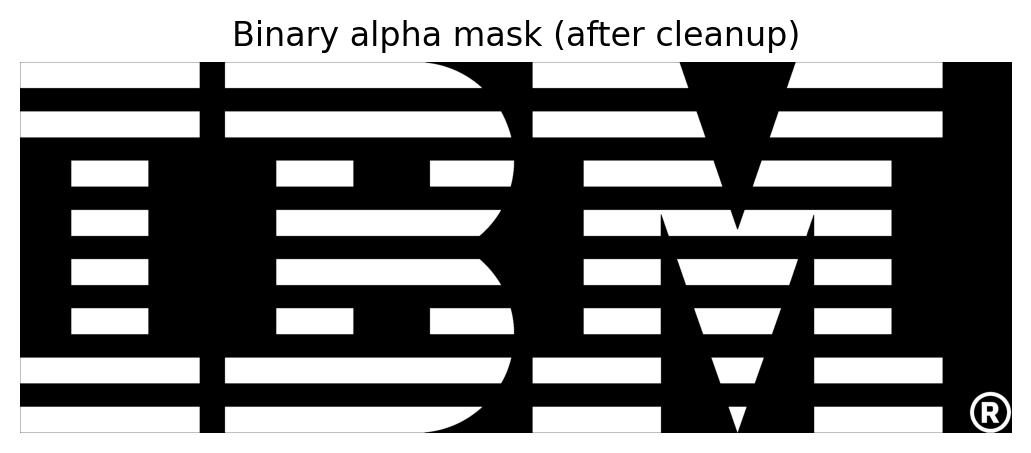

In [4]:
def rgba_to_mask(img_rgba: Image.Image, config: SvgPngToGeoConfig) -> np.ndarray:
    """Convert an RGBA image to a cleaned binary mask based on alpha."""
    arr = np.asarray(img_rgba)
    alpha = arr[:, :, 3]
    mask = alpha > config.alpha_threshold

    if config.close_radius_px > 0:
        selem = morphology.disk(config.close_radius_px)
        mask = morphology.binary_closing(mask, selem)

    if config.remove_small_objects_min_px > 0:
        mask = morphology.remove_small_objects(mask, min_size=config.remove_small_objects_min_px)

    # Pad to stabilize contour finding at the image boundary.
    mask = np.pad(mask, pad_width=1, mode="constant", constant_values=False)
    return mask


def contours_to_polygons(mask: np.ndarray) -> List[Polygon]:
    """Extract polygon rings from a binary mask via marching squares contours."""
    contours = measure.find_contours(mask.astype(np.float32), level=0.5)
    height, width = mask.shape

    polys: List[Polygon] = []
    for c in contours:
        # c is (row, col). Convert to (x, y) with y increasing upward.
        x = c[:, 1]
        y = (height - 1) - c[:, 0]
        coords = np.column_stack([x, y])

        coords = _dedupe_consecutive(coords)
        if coords.shape[0] < 3:
            continue

        poly = Polygon(coords)
        if not poly.is_valid:
            poly = poly.buffer(0)

        for p in _flatten_to_polygons(poly):
            if p.area > 0:
                polys.append(p)

    return polys


def build_solids_with_holes(polys: Sequence[Polygon]) -> List[Polygon]:
    """Classify nested contours into solids (even depth) with holes (odd depth)."""
    n = len(polys)
    if n == 0:
        return []

    bounds = [p.bounds for p in polys]  # (minx, miny, maxx, maxy)
    areas = [p.area for p in polys]

    def bbox_contains(b_out: Tuple[float, float, float, float],
                      b_in: Tuple[float, float, float, float]) -> bool:
        return (b_out[0] <= b_in[0] and b_out[1] <= b_in[1]
                and b_out[2] >= b_in[2] and b_out[3] >= b_in[3])

    parents = [-1] * n
    for i in range(n):
        best_parent = -1
        best_area = float("inf")
        for j in range(n):
            if areas[j] <= areas[i]:
                continue
            if not bbox_contains(bounds[j], bounds[i]):
                continue
            if polys[j].contains(polys[i]) and areas[j] < best_area:
                best_parent = j
                best_area = areas[j]
        parents[i] = best_parent

    children: List[List[int]] = [[] for _ in range(n)]
    for i, p in enumerate(parents):
        if p != -1:
            children[p].append(i)

    depths = [0] * n
    for i in range(n):
        d = 0
        cur = i
        while parents[cur] != -1:
            cur = parents[cur]
            d += 1
        depths[i] = d

    solids: List[Polygon] = []
    for i in range(n):
        if depths[i] % 2 != 0:
            continue  # holes are not solids

        hole_rings = []
        for ch in children[i]:
            if depths[ch] == depths[i] + 1:
                hole_rings.append(list(polys[ch].exterior.coords))

        solid = Polygon(polys[i].exterior.coords, holes=hole_rings)
        if not solid.is_valid:
            solid = solid.buffer(0)

        solids.extend(_flatten_to_polygons(solid))

    return solids


mask = rgba_to_mask(img_rgba, CONFIG)
raw_contours = contours_to_polygons(mask)
solids_px = build_solids_with_holes(raw_contours)

print(f"Contours extracted: {len(raw_contours)}")
print(f"Solid polygons (pre-scale): {len(solids_px)}")

plt.figure()
plt.title("Binary alpha mask (after cleanup)")
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()


Final bounds (mm): (0.0, 0.0, 1.0, 0.373530147610708)
Final width (mm): 1.0
Final height (mm): 0.373530147610708
Final polygon count: 39


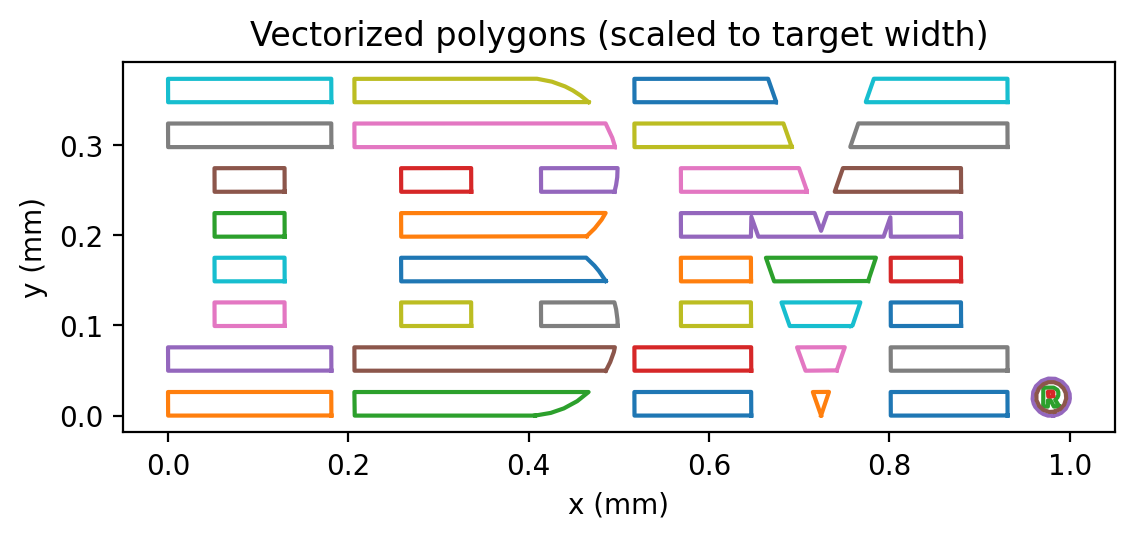

In [5]:
def scale_polygons_to_width_mm(polys_px: Sequence[Polygon],
                               target_width_mm: float) -> List[Polygon]:
    """Scale polygons so their overall horizontal span becomes target_width_mm."""
    if not polys_px:
        return []

    merged = unary_union(list(polys_px))
    merged_polys = _flatten_to_polygons(merged)

    minx, miny, maxx, maxy = merged.bounds
    width_px = maxx - minx
    if width_px <= 0:
        raise ValueError("Degenerate width detected in vectorized geometry.")

    scale_factor = target_width_mm / width_px

    out: List[Polygon] = []
    for p in merged_polys:
        p2 = shp_translate(p, xoff=-minx, yoff=-miny)
        p3 = shp_scale(p2, xfact=scale_factor, yfact=scale_factor, origin=(0.0, 0.0))
        out.append(p3)

    return out


def simplify_polygons_mm(polys_mm: Sequence[Polygon],
                         tolerance_mm: float,
                         min_area_mm2: float) -> List[Polygon]:
    """Simplify polygons (in mm units) while preserving topology."""
    out: List[Polygon] = []
    for p in polys_mm:
        p2 = p.simplify(tolerance_mm, preserve_topology=True)
        for q in _flatten_to_polygons(p2):
            if q.area >= min_area_mm2:
                out.append(q)
    return out


solids_mm = scale_polygons_to_width_mm(solids_px, CONFIG.target_width_mm)
solids_mm = simplify_polygons_mm(solids_mm,
                                 tolerance_mm=CONFIG.simplify_tolerance_mm,
                                 min_area_mm2=CONFIG.min_polygon_area_mm2)

merged_mm = unary_union(list(solids_mm)) if solids_mm else None
bounds_mm = merged_mm.bounds if merged_mm else (0.0, 0.0, 0.0, 0.0)

print("Final bounds (mm):", bounds_mm)
print("Final width (mm):", bounds_mm[2] - bounds_mm[0])
print("Final height (mm):", bounds_mm[3] - bounds_mm[1])
print(f"Final polygon count: {len(solids_mm)}")


def plot_polygons_mm(polys: Sequence[Polygon], title: str) -> None:
    """Plot shapely polygons in mm coordinates."""
    plt.figure()
    plt.title(title)
    for p in polys:
        ext = np.asarray(p.exterior.coords)
        plt.plot(ext[:, 0], ext[:, 1])
        for hole in p.interiors:
            h = np.asarray(hole.coords)
            plt.plot(h[:, 0], h[:, 1])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.show()


plot_polygons_mm(solids_mm, "Vectorized polygons (scaled to target width)")


In [6]:
def polygons_to_gmsh_geo(polys_mm: Sequence[Polygon],
                         config: SvgPngToGeoConfig,
                         out_path: Path) -> None:
    """Write polygons to a Gmsh .geo file with edge-refined sizing field."""
    lc_min, lc_max, dist_min, dist_max = _derive_mesh_sizes(config)

    lines: List[str] = []
    lines.append('// Generated by a Colab SVG/PNG -> Gmsh GEO converter')
    lines.append('// Units are interpreted as millimeters (Gmsh itself is unitless).')
    if config.use_opencascade_factory:
        lines.append('SetFactory("OpenCASCADE");')
    lines.append("")
    lines.append(f"lcMin = {lc_min:.17g};")
    lines.append(f"lcMax = {lc_max:.17g};")
    lines.append(f"distMin = {dist_min:.17g};")
    lines.append(f"distMax = {dist_max:.17g};")
    lines.append(f"distanceSampling = {int(config.distance_sampling)};")
    lines.append(f"do3D = {1 if config.generate_3d else 0};")
    lines.append(f"thickness = {config.extrude_thickness_mm:.17g};")
    lines.append(f"layers = {int(config.extrude_layers)};")
    lines.append("")

    pid = 1
    lid = 1
    clid = 1
    sid = 1
    surface_ids: List[int] = []

    def emit_ring(coords_xy: np.ndarray, clockwise: bool) -> Tuple[List[int], List[int], int]:
        """Emit points/lines/curve-loop for a ring; return (line_ids, point_ids, loop_id)."""
        nonlocal pid, lid, clid

        coords_xy = _dedupe_consecutive(coords_xy)
        coords_xy = _decimate_ring(coords_xy, config.max_points_per_ring)
        coords_xy = _dedupe_consecutive(coords_xy)
        if coords_xy.shape[0] < 3:
            raise ValueError("Ring collapsed below 3 points after decimation/deduplication.")
        coords_xy = _ensure_orientation(coords_xy, clockwise=clockwise)

        point_ids: List[int] = []
        for x, y in coords_xy:
            lines.append(f"Point({pid}) = {{{x:.17g}, {y:.17g}, 0, lcMin}};")
            point_ids.append(pid)
            pid += 1

        line_ids: List[int] = []
        for i in range(len(point_ids)):
            a = point_ids[i]
            b = point_ids[(i + 1) % len(point_ids)]
            lines.append(f"Line({lid}) = {{{a}, {b}}};")
            line_ids.append(lid)
            lid += 1

        lines.append(f"Curve Loop({clid}) = {{{', '.join(str(x) for x in line_ids)}}};")
        loop_id = clid
        clid += 1
        return line_ids, point_ids, loop_id

    for poly in polys_mm:
        # Exterior ring (CCW)
        ext = np.asarray(poly.exterior.coords)[:-1]
        _, _, outer_loop = emit_ring(ext, clockwise=False)

        # Holes (CW)
        hole_loops: List[int] = []
        for hole in poly.interiors:
            h = np.asarray(hole.coords)[:-1]
            _, _, hole_loop = emit_ring(h, clockwise=True)
            hole_loops.append(hole_loop)

        loops_all = [outer_loop] + hole_loops
        lines.append(f"Plane Surface({sid}) = {{{', '.join(str(x) for x in loops_all)}}};")
        surface_ids.append(sid)
        sid += 1
        lines.append("")

    if not surface_ids:
        raise RuntimeError("No valid polygons were produced. Check alpha threshold and cleanup.")

    lines.append(f"allSurfaces[] = {{{', '.join(str(x) for x in surface_ids)}}};")
    lines.append("")

    if not config.generate_3d:
        # 2D: boundary curves for distance-based refinement.
        lines.append("bndCurves[] = Boundary{ Surface{allSurfaces[]}; };")
        lines.append('Physical Surface("design") = {allSurfaces[]};')
        lines.append('Physical Curve("design_boundary") = {bndCurves[]};')
        lines.append("")

        if config.write_mesh_field:
            lines.append("// Distance -> Threshold background mesh sizing field")
            lines.append("Field[1] = Distance;")
            lines.append("Field[1].CurvesList = {bndCurves[]};")
            lines.append("Field[1].Sampling = distanceSampling;")
            lines.append("Field[2] = Threshold;")
            lines.append("Field[2].InField = 1;")
            lines.append("Field[2].SizeMin = lcMin;")
            lines.append("Field[2].SizeMax = lcMax;")
            lines.append("Field[2].DistMin = distMin;")
            lines.append("Field[2].DistMax = distMax;")
            bg_field = 2

            if config.use_boundary_layer_field:
                # Optional: boundary layer mesh near edges (often helpful for CFD).
                # BoundaryLayer examples are commonly expressed via EdgesList and hwall_n/thickness.
                lines.append("")
                lines.append("// Optional BoundaryLayer field (often for CFD near walls)")
                lines.append("Field[3] = BoundaryLayer;")
                lines.append("Field[3].EdgesList = {bndCurves[]};")
                lines.append(f"Field[3].hwall_n = {config.boundary_layer_first_layer_mm:.17g};")
                lines.append(f"Field[3].thickness = {config.boundary_layer_thickness_mm:.17g};")
                lines.append(f"Field[3].ratio = {config.boundary_layer_growth_ratio:.17g};")
                lines.append(f"Field[3].Quads = {int(config.boundary_layer_quads)};")
                lines.append("BoundaryLayer Field = 3;")
                lines.append("")
                lines.append("// Combine fields by taking the minimum target size")
                lines.append("Field[4] = Min;")
                lines.append("Field[4].FieldsList = {2, 3};")
                bg_field = 4

            lines.append(f"Background Field = {bg_field};")
            lines.append("")
            lines.append("// Let the field dominate sizing (disable other automatic sources)")
            lines.append("Mesh.MeshSizeExtendFromBoundary = 0;")
            lines.append("Mesh.MeshSizeFromPoints = 0;")
            lines.append("Mesh.MeshSizeFromCurvature = 0;")
            lines.append("")
            lines.append("// Mesh 2D by default when you open this in Gmsh")
            lines.append("Mesh 2;")

    else:
        # 3D: extrude each surface and gather volumes.
        # Gmsh's extrude returns IDs with the "top" at index 0 and the new entity at index 1,
        # followed by lateral entities. :contentReference[oaicite:3]{index=3}
        lines.append("vols[] = {};")
        lines.append("topSurfaces[] = {};")
        lines.append("sideSurfaces[] = {};")
        lines.append("")

        for s in surface_ids:
            lines.append(f"out{s}[] = Extrude {{0, 0, thickness}} {{")
            lines.append(f"  Surface{{{s}}};")
            lines.append("  Layers{layers};")
            lines.append("};")
            lines.append(f"vols[] += out{s}[1];")
            lines.append(f"topSurfaces[] += out{s}[0];")
            lines.append("")

        lines.append("bndSurfaces[] = Boundary{ Volume{vols[]}; };")
        lines.append('Physical Volume("design") = {vols[]};')
        lines.append('Physical Surface("design_boundary") = {bndSurfaces[]};')
        lines.append("")

        if config.write_mesh_field:
            # In 3D, interpret “edge proximity” as proximity to boundary surfaces.
            lines.append("// Distance -> Threshold sizing field in 3D, driven by boundary surfaces")
            lines.append("Field[1] = Distance;")
            lines.append("Field[1].SurfacesList = {bndSurfaces[]};")
            lines.append("Field[1].Sampling = distanceSampling;")
            lines.append("Field[2] = Threshold;")
            lines.append("Field[2].InField = 1;")
            lines.append("Field[2].SizeMin = lcMin;")
            lines.append("Field[2].SizeMax = lcMax;")
            lines.append("Field[2].DistMin = distMin;")
            lines.append("Field[2].DistMax = distMax;")
            bg_field = 2

            if config.use_boundary_layer_field:
                lines.append("")
                lines.append("// Optional BoundaryLayer in 3D: usually uses FacesList")
                lines.append("Field[3] = BoundaryLayer;")
                lines.append("Field[3].FacesList = {bndSurfaces[]};")
                lines.append(f"Field[3].hwall_n = {config.boundary_layer_first_layer_mm:.17g};")
                lines.append(f"Field[3].thickness = {config.boundary_layer_thickness_mm:.17g};")
                lines.append(f"Field[3].ratio = {config.boundary_layer_growth_ratio:.17g};")
                lines.append(f"Field[3].Quads = {int(config.boundary_layer_quads)};")
                lines.append("BoundaryLayer Field = 3;")
                lines.append("")
                lines.append("Field[4] = Min;")
                lines.append("Field[4].FieldsList = {2, 3};")
                bg_field = 4

            lines.append(f"Background Field = {bg_field};")
            lines.append("")
            lines.append("Mesh.MeshSizeExtendFromBoundary = 0;")
            lines.append("Mesh.MeshSizeFromPoints = 0;")
            lines.append("Mesh.MeshSizeFromCurvature = 0;")
            lines.append("")
            lines.append("Mesh 3;")

    out_path.write_text("\n".join(lines), encoding="utf-8")


stem = Path(uploaded_name).stem
mode = "3d" if CONFIG.generate_3d else "2d"
out_geo = Path(f"{stem}_scaled_{CONFIG.target_width_mm:g}mm_{mode}.geo")

polygons_to_gmsh_geo(solids_mm, CONFIG, out_geo)
print(f"Wrote GEO: {out_geo.resolve()}")

# Display the full GEO text (may be long for detailed silhouettes).
geo_text = out_geo.read_text(encoding="utf-8")
print("\n===== BEGIN GEO FILE =====\n")
print(geo_text)
print("\n===== END GEO FILE =====\n")


Wrote GEO: /content/IBM_logo_scaled_1mm_2d.geo

===== BEGIN GEO FILE =====

// Generated by a Colab SVG/PNG -> Gmsh GEO converter
// Units are interpreted as millimeters (Gmsh itself is unitless).
SetFactory("OpenCASCADE");

lcMin = 0.003003003003003003;
lcMax = 0.012012012012012012;
distMin = 0.003003003003003003;
distMax = 0.015015015015015015;
distanceSampling = 200;
do3D = 0;
thickness = 0.10000000000000001;
layers = 1;

Point(1) = {0.64660995746810102, 0.026269702276707531, 0, lcMin};
Point(2) = {0.51713785339004248, 0.026144608456342255, 0, lcMin};
Point(3) = {0.51726294721040778, 0, 0, lcMin};
Point(4) = {0.64673505128846631, 0.00012509382036527395, 0, lcMin};
Line(1) = {1, 2};
Line(2) = {2, 3};
Line(3) = {3, 4};
Line(4) = {4, 1};
Curve Loop(1) = {1, 2, 3, 4};
Plane Surface(1) = {1};

Point(5) = {0.18101075806855141, 0.026269702276707531, 0, lcMin};
Point(6) = {0, 0.026144608456342255, 0, lcMin};
Point(7) = {0.00012509382036527395, 0, 0, lcMin};
Point(8) = {0.18113585188891668, 

In [7]:
from google.colab import files  # pylint: disable=import-error

files.download(str(out_geo))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>